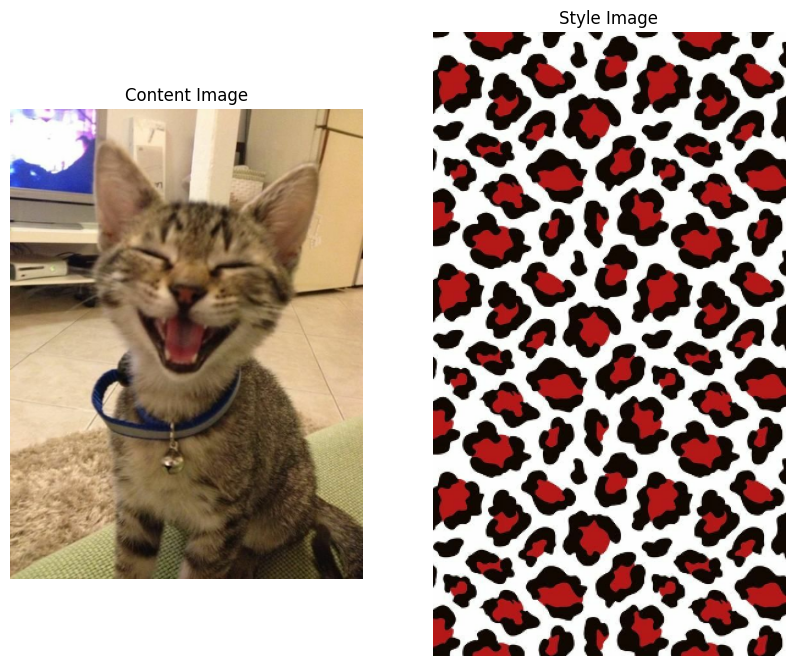

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Mulai proses training (Estimasi: 2-3 menit)...
..................................................
Epoch 1/5 selesai.


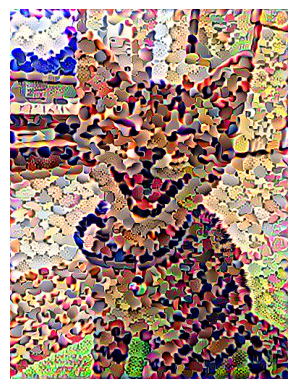

..................................................
Epoch 2/5 selesai.


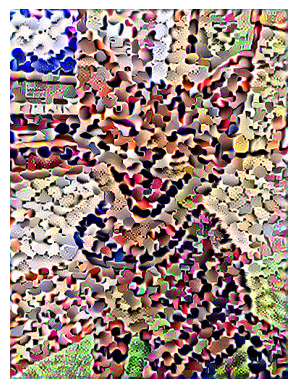

..................................................
Epoch 3/5 selesai.


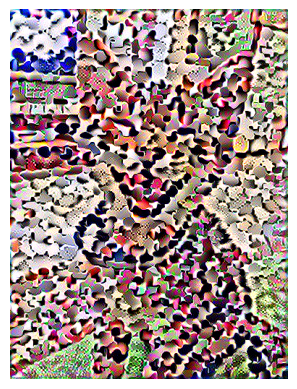

..................................................
Epoch 4/5 selesai.


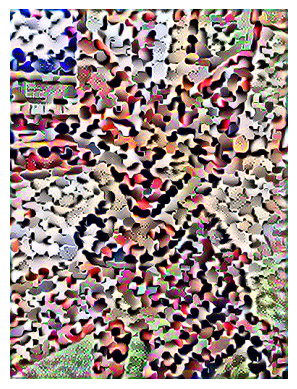

..................................................
Epoch 5/5 selesai.


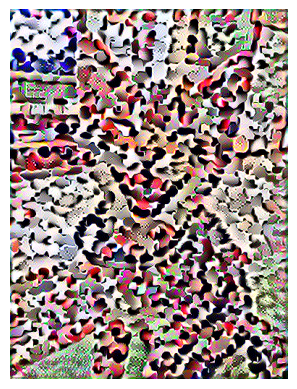

Total waktu: 1741.9 detik
Gambar disimpan sebagai hasil_manual_gram_matrix.jpg


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import time

# Fungsi untuk memuat gambar dan membatasi ukuran (supaya tidak Out of Memory)
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

# Fungsi untuk menampilkan gambar
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.imshow(image)
  if title:
    plt.title(title)
  plt.axis('off')

# --- MASUKKAN NAMA FILE GAMBAR ANDA DISINI ---
content_path = '/content/drive/MyDrive/deep learning lanjut/model.jpg'  # Ganti dengan gambar utamamu
style_path   = '/content/drive/MyDrive/deep learning lanjut/style.jpg'   # Ganti dengan gambar stylemu

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1); imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2); imshow(style_image, 'Style Image')
plt.show()


# Kita menggunakan VGG19 yang sudah dilatih (Pre-trained)
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# Layer yang digunakan untuk Style dan Content (Standar paper NST)
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Membangun model ekstraktor fitur
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

# --- RUMUS GRAM MATRIX (Sesuai Halaman 24 Materi ) ---
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # Menghitung Gram Matrix untuk setiap layer style
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

# Setup ekstraktor
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']


# Setup gambar awal (variabel yang akan dioptimasi)
image = tf.Variable(content_image)

# Bobot untuk mengatur seberapa kuat Style vs Content
style_weight=1e-2
content_weight=1e4

# Optimizer (Adam digunakan agar lebih cepat stabil dibanding L-BFGS murni)
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Fungsi Loss Total
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    # Hitung Style Loss (Error Gram Matrix)
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    # Hitung Content Loss (Error L2) [cite: 148]
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

# Langkah Training satu step
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image, 0.0, 1.0))

# --- JALANKAN PROSES TRAINING ---
print("Mulai proses training (Estimasi: 2-3 menit)...")

epochs = 5
steps_per_epoch = 50

start = time.time()

for n in range(epochs):
  for m in range(steps_per_epoch):
    train_step(image)
    print(".", end='', flush=True)

  # Tampilkan hasil setiap epoch
  print(f"\nEpoch {n+1}/{epochs} selesai.")
  plt.imshow(image.read_value()[0])
  plt.axis('off')
  plt.show()

end = time.time()
print("Total waktu: {:.1f} detik".format(end-start))

# Simpan hasil akhir
file_name = 'hasil_manual_gram_matrix.jpg'
tf.keras.preprocessing.image.save_img(file_name, image.read_value()[0])
print(f"Gambar disimpan sebagai {file_name}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
